In [ ]:
!pip install rasterio # Install the rasterio library using pip

In [ ]:
pip install geopandas

In [10]:
# Import necessary libraries
import numpy as np  # NumPy for numerical operations
import rasterio  # Rasterio for working with geospatial raster data
import matplotlib.pyplot as plt  # Matplotlib for plotting
import random  # Random for generating random values
from sklearn import preprocessing  # Scikit-learn for preprocessing tasks

import os
import rasterio
from glob import glob
import matplotlib.pyplot as plt
#import rasterio as rio
from rasterio.plot import plotting_extent
import geopandas as gpd
import earthpy as et
import earthpy.spatial as es
import earthpy.plot 

In [20]:
import os
from osgeo import gdal, ogr, gdalconst
import numpy as np

def clip_raster(raster_path, shapefile_path, output_path):
    # Open raster dataset
    raster_ds = gdal.Open(raster_path, gdalconst.GA_ReadOnly)
    if raster_ds is None:
        print(f"Error: Unable to open raster dataset {raster_path}")
        return
    
    # Open shapefile
    shapefile_ds = ogr.Open(shapefile_path)
    if shapefile_ds is None:
        print(f"Error: Unable to open shapefile {shapefile_path}")
        return
    
    # Get shapefile layer
    layer = shapefile_ds.GetLayer()
    # Get layer's spatial reference
    layer_srs = layer.GetSpatialRef()
    
    # Get raster extent
    raster_extent = gdal.Info(raster_ds, format='json')['cornerCoordinates']
    xmin, ymin = raster_extent['lowerLeft']
    xmax, ymax = raster_extent['upperRight']
    
    # Create memory file to hold the output
    mem_driver = gdal.GetDriverByName('MEM')
    mem_ds = mem_driver.Create('', raster_ds.RasterXSize, raster_ds.RasterYSize, 1, raster_ds.GetRasterBand(1).DataType)
    mem_ds.SetProjection(raster_ds.GetProjection())
    mem_ds.SetGeoTransform((xmin, (xmax-xmin)/mem_ds.RasterXSize, 0, ymax, 0, (ymin-ymax)/mem_ds.RasterYSize))
    
    # Rasterize shapefile to memory file
    gdal.RasterizeLayer(mem_ds, [1], layer, burn_values=[1])
    
    # Read raster data as numpy array
    raster_array = raster_ds.GetRasterBand(1).ReadAsArray()
    # Mask raster array using shapefile
    raster_array_masked = np.where(mem_ds.GetRasterBand(1).ReadAsArray(), raster_array, np.nan)
    
    # Create output raster
    driver = gdal.GetDriverByName('GTiff')
    output_ds = driver.Create(output_path, mem_ds.RasterXSize, mem_ds.RasterYSize, 1, gdal.GDT_Float32)
    output_ds.SetProjection(mem_ds.GetProjection())
    output_ds.SetGeoTransform(mem_ds.GetGeoTransform())
    output_band = output_ds.GetRasterBand(1)
    output_band.WriteArray(raster_array_masked)
    output_band.SetNoDataValue(np.nan)
    
    # Close datasets
    raster_ds = None
    shapefile_ds = None
    mem_ds = None
    output_ds = None
    
    print(f"Clipped raster saved to {output_path}")

# Paths
raster_path = '/home/eoafrica/RF_model/annotated_image/annotated_image.tif' 
shapefile_path = '/home/eoafrica/RF_model/shapefile/studyarea_bound.shp'
output_path = '/home/eoafrica/RF_model/test1_annotated/annotated_image.tif'

# Clip raster
clip_raster(raster_path, shapefile_path, output_path)


Clipped raster saved to /home/eoafrica/RF_model/test1_annotated/annotated_image.tif


### Layerstacking

Stacked bands saved successfully to /home/eoafrica/RF_model/outputs_rgb/siia_stacked_rgb.tif


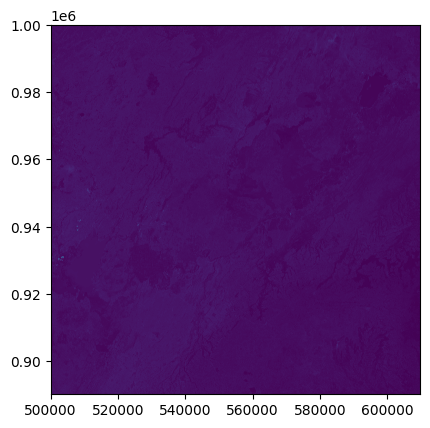

In [11]:
import os
import numpy as np
import rasterio
from rasterio.merge import merge
from rasterio.plot import show
import matplotlib.pyplot as plt

# Function to stack Sentinel-2 bands
def stack_sentinel_bands(input_folder, output_path):
    # List all tif files in the input folder
    files = [os.path.join(input_folder, f) for f in os.listdir(input_folder) if f.endswith('.tif')]

    # Read metadata of first file
    with rasterio.open(files[0]) as src0:
        meta = src0.meta

    # Update metadata for the stacked file
    meta.update(count = len(files))

    # Read each layer and store them in an array
    arr_stack = []
    for f in files:
        with rasterio.open(f) as src:
            arr_stack.append(src.read(1))

    # Stack the arrays
    stacked_array = np.stack(arr_stack)

    # Write the stacked array to a new tif file
    with rasterio.open(output_path, 'w', **meta) as dst:
        dst.write(stacked_array)

    print("Stacked bands saved successfully to", output_path)

# Specify input folder and output path
input_folder = '/home/eoafrica/RF_model/sentinel_2Aimages'
output_path = '/home/eoafrica/RF_model/outputs_rgb/stacked_rgb.tif'

# Stack bands
stack_sentinel_bands(input_folder, output_path)

# Visualize the stacked bands
with rasterio.open(output_path) as src:
    show(src)


In [13]:
# Load Sentinel 2 image
sentinel_path = '/home/eoafrica/RF_model/outputs_rgb/stacked_rgb.tif'
sentinel_data = rasterio.open(sentinel_path)
sentinel_bands = sentinel_data.read()